# Wisconsin Card Sort

The following experiment learns to solve the Wisconsin Card Sort via reinforcement learning

In [1]:
from tensorflow.keras.layers import Input, Dense, Flatten
import tensorflow as tf

import itertools
import numpy as np
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt

from keras_context.switches import TdErrorSwitch
from keras_context.callbacks import ContextLogger
from keras_context.layers import Context
from keras_context.models import ContextModel
from keras_context.flags import Verbosity
from keras_context.utils import set_seed

In [2]:
def random_card():
    """
    Generate a one-hot encoded card.
    Returns a tuple of the card and the expected output label
    """
    x = np.identity(3)
    np.random.shuffle(x)
    return x

In [3]:
def policy(predicted, epsilon):
    if np.random.random() < epsilon:
        return np.random.randint(3), True
    return np.argmax(predicted), False

In [4]:
def reward(sort, rule):
    if sort == rule:
        return 1.0
    return -1.0

In [46]:
def episode(model, ctx_map, rule, ep, epsilon=0.01, alpha=1.0, auto_switch=True, deltas={}, **kwargs):
    
#     print(f"{ep}:")
    
    # Action choices
    actions = np.identity(3)
    
    # Random card to sort
    card = random_card()
    
    # Create the possible inputs to feed into the neural network
    inputs = np.array([np.vstack((a, card)) for a in actions])
    
    # Predict and sort
    values = model.predict(inputs)
    action, is_random = policy(values.flatten(), epsilon)
    r = reward(action, rule)
    
#     if is_random:
#         print(f"{ep} Random action taken:", action)
        
    # Q-learning update
    q_old = values[action][0]
    target = np.array([[q_old + alpha*(r - q_old)]])
    
    # Update the model
    x = np.array([np.vstack((actions[action], card))])
    if not auto_switch and ctx_map[model.get_contexts()[0]] != rule and action in (ctx_map[model.get_contexts()[0]], rule):
        old_ctx = model.get_contexts()[0]
        model.fit(x, target, train_after_switch=False, retry_fit=False, revert_after_fit=True, auto_switch=False, **kwargs)
        deltas[ep] = model.layers[model.ctx_layers[0]].switch_model.delta.numpy()
        model.layers[model.ctx_layers[0]].next_context()
        if action == rule:
            print(ep, f"Found the correct context early through an exploratory move. Switch to next sequential context: {model.get_contexts()[0]}")
        else:
            print(ep, f"Determined context is incorrect... Trying the next context: {model.get_contexts()[0]}")
    else:
        model.fit(x, target, train_after_switch=False, retry_fit=False, auto_switch=auto_switch, **kwargs)
    
    return action == rule, is_random

In [47]:
def wisconsin_card_sort(model, episodes, switch_freq=75, epsilon=0.01, alpha=1.0, auto_switch=True, initial_shuffle=False, shuffle=True, true_random=False, deltas={}, **kwargs):
    NUM_DIMENSIONS = 3
    if not true_random:
        rules = np.arange(NUM_DIMENSIONS)
        if initial_shuffle:
            np.random.shuffle(rules)
        ctx_map = rules.copy()
        rule, rules = rules[0], rules[1:]
    else:
        rules = []
        rule = np.random.randint(NUM_DIMENSIONS)
        ctx_map = None
    
    print("Rule is:", rule)
    for ep in range(episodes):
        # Perform the episode. Count the sequentially correct episodes
        is_correct, is_random = episode(model, ctx_map, rule, ep, epsilon, alpha, auto_switch=auto_switch, deltas=deltas, **kwargs)
            
        # Change the rule once the model has learned the rule
        if ep > 0 and ep % switch_freq == 0:
            if shuffle:
                if len(rules) == 0:
                    old_rule = rule
                    while rule == old_rule:
                        rule = np.random.randint(NUM_DIMENSIONS)
                else:
                    rule, rules = rules[0], rules[1:]
            else:
                rule = (rule + 1) % NUM_DIMENSIONS
                        
            print(f"\nEpisode: {ep+1}; New rule is:", rule, '\n')

In [7]:
def all_possible_inputs():
    result = []
    for card in itertools.permutations(np.identity(3)):
        for action in np.identity(3):
            result.append(np.vstack((action, card)))
    return np.array(result)

def evaluate_model(model):
    # Get the current model state
    contexts = model.get_contexts()
    
    # Generate all possible input combinations
    inputs = all_possible_inputs()
    
    rules = set(range(3))
    
    accuracy_map = []
    for context in range(3):
        model.set_contexts([context])
        predictions = model.predict(inputs).reshape((6,3,1))
        accuracy_map.append(np.bincount(np.argmax(predictions, axis=1).flatten(), minlength=3) / 6)
    
    # Brute force best-fit because I'm too lazy :p
    best_accuracy = 0
    best_mapping = None
    for mapping in itertools.permutations(range(3)):
        accuracy = np.mean([accuracy_map[i][j] for i, j in enumerate(mapping)])
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_mapping = mapping
            
    # Restore the model state
    model.set_contexts(contexts)
    
    return best_accuracy, best_mapping

## Static n-task Learning

In [61]:
set_seed(10)

In [62]:
# Optimizer
optimizer = tf.keras.optimizers.SGD(1e-1)

# Hyperparameters
hrr_size = 512
num_contexts = 3
switch_threshold = -8e-6

# Model Architecture
inp = Input((4,3))
x = Flatten()(inp)
x = Dense(hrr_size, activation="relu", use_bias=False)(x)
x = Context(num_contexts, TdErrorSwitch(0.05, switch_threshold, initial_loss = 20e-5, init_multiplier=10))(x)
x = Dense(1, activation="linear", use_bias=False)(x)

# Create the model
model = ContextModel(inputs=inp, outputs=x)

# Compile the model
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=optimizer)

In [ ]:
episodes = 600
seq_correct = 100
epsilon = 0.1
alpha = 1.0

logger = ContextLogger(track_epochs_internally=True)
callbacks = [logger]

deltas = {}

wisconsin_card_sort(model, episodes, seq_correct, epsilon, alpha, auto_switch=True, deltas=deltas, initial_shuffle=True, shuffle=True, callbacks=callbacks, verbose=0)

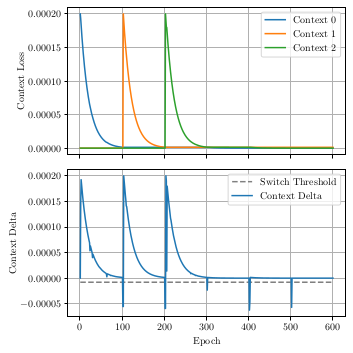

In [35]:
logger.plot(figsize=(5,5), savefile="graphs/wcst_static.pgf")

In [563]:
evaluate_model(model) # accuracy, context->rule map

(1.0, (0, 2, 1))

## 2. Dynamic n-Task

In [56]:
set_seed(16)

In [57]:
# Optimizer
optimizer = tf.keras.optimizers.SGD(1e-1)

# Hyperparameters
hrr_size = 512
num_contexts = 3
switch_threshold = -8e-6
add_threshold = -16e-6

# Model Architecture
inp = Input((4,3))
x = Flatten()(inp)
x = Dense(hrr_size, activation="relu", use_bias=False)(x)
x = Context(1, TdErrorSwitch(0.05, switch_threshold, initial_loss = 20e-5, init_multiplier=10, add_threshold=add_threshold, max_contexts=num_contexts))(x)
x = Dense(1, activation="linear", use_bias=False)(x)

# Create the model
model = ContextModel(inputs=inp, outputs=x)

# Compile the model
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=optimizer)

In [58]:
episodes = 600
seq_correct = 100
epsilon = 0.1
alpha = 1.0

logger = ContextLogger(track_epochs_internally=True)
callbacks = [logger]

deltas = {}

wisconsin_card_sort(model, episodes, seq_correct, epsilon, alpha, auto_switch=True, deltas=deltas, true_random=True, shuffle=True, callbacks=callbacks, verbose=0)

Rule is: 1

Episode: 101; New rule is: 2 


Episode: 201; New rule is: 1 


Episode: 301; New rule is: 0 


Episode: 401; New rule is: 2 


Episode: 501; New rule is: 0 



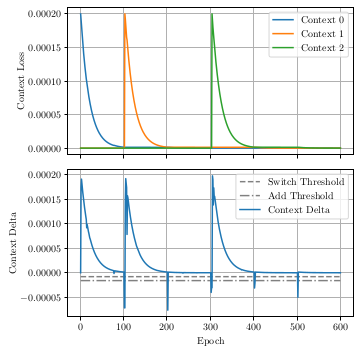

In [61]:
logger.plot(figsize=(5,5), savefile="graphs/wcst_dynamic.pgf")

## Delta Analysis

This section analyzes the context deltas using emulated context switching. This assumes optimal switching behavior, but can be helpful to generalize appropriate hyperparameters

Through the analysis of emulated switching with 100% accuracy, the theoretical best that could be achieved with the given settings is 84/100. This theoretical value is only valid for models that switch exactly when they're supposed to. There are however models that may learn under the incorrect context and remap over time.

In [139]:
%time !python3 ./wcst_task.py 100 12

CPU times: user 2.26 s, sys: 536 ms, total: 2.79 s
Wall time: 2min 43s


In [ ]:
# Load the model results
with open("data/wcst_analysis2.dat", 'rb') as f:
    data = pickle.load(f)

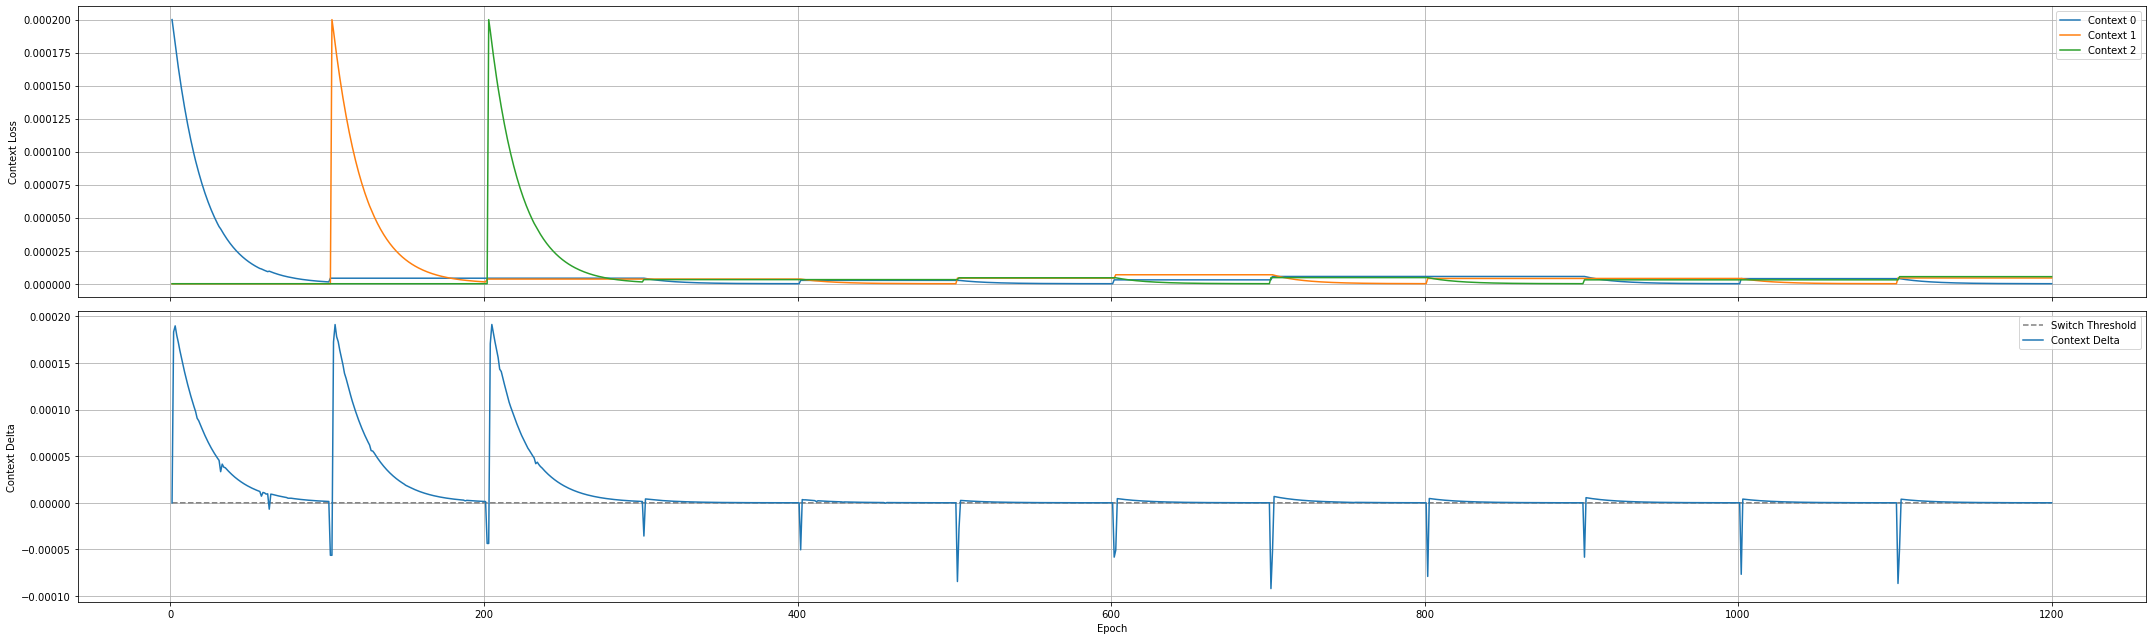

In [331]:
logger = ContextLogger()
logger.plots = data[(2,3)][0]
logger.plot()

In [203]:
data[(1,3)][1]

{101: -2.1038373e-05,
 201: -7.32481e-05,
 301: -2.342306e-05,
 401: -4.094155e-05,
 402: 3.8976295e-06,
 501: -6.127228e-05,
 502: -5.6329976e-05,
 601: -3.547248e-05,
 602: -3.4033914e-05,
 701: -6.455995e-05,
 702: -4.07734e-05,
 801: -6.5930915e-05,
 802: -7.261839e-05,
 901: -2.7628244e-05,
 1001: -3.5117875e-05,
 1002: -2.5052625e-05,
 1101: -4.6291327e-05}

In [244]:
largest_deltas = []
for key in data:
    largest_deltas.append((max(data[key][1].values()), key))
largest_deltas
np.mean([v[0] for v in largest_deltas])

-1.8736868e-05

In [388]:
correct = []
threshold = -8e-6
for key in data:
    if threshold > max(np.array(list(data[key][1].values()))):
        deltas = np.array(list(data[key][0].values())[0][(None, 'Epoch', 'Context Delta')]['Context Delta']['y'])
        for k in data[key][1]: # Remove the switch locations
            deltas[k] = 0.0
        for k in (102, 202, 302): # Remove the prevent update locations
            deltas[k] = 0.0
        if threshold < min(deltas):
            correct.append(key)

In [389]:
len(correct)

84

In [577]:
sorted(correct)

[(0, 3),
 (2, 3),
 (3, 3),
 (4, 3),
 (5, 3),
 (7, 3),
 (8, 3),
 (9, 3),
 (10, 3),
 (11, 3),
 (12, 3),
 (13, 3),
 (15, 3),
 (17, 3),
 (18, 3),
 (19, 3),
 (20, 3),
 (21, 3),
 (24, 3),
 (25, 3),
 (26, 3),
 (27, 3),
 (28, 3),
 (29, 3),
 (30, 3),
 (31, 3),
 (32, 3),
 (34, 3),
 (35, 3),
 (36, 3),
 (37, 3),
 (38, 3),
 (39, 3),
 (40, 3),
 (41, 3),
 (42, 3),
 (44, 3),
 (45, 3),
 (46, 3),
 (47, 3),
 (48, 3),
 (49, 3),
 (50, 3),
 (52, 3),
 (53, 3),
 (54, 3),
 (55, 3),
 (56, 3),
 (60, 3),
 (62, 3),
 (63, 3),
 (64, 3),
 (65, 3),
 (66, 3),
 (67, 3),
 (68, 3),
 (69, 3),
 (70, 3),
 (71, 3),
 (72, 3),
 (73, 3),
 (74, 3),
 (75, 3),
 (76, 3),
 (77, 3),
 (78, 3),
 (79, 3),
 (80, 3),
 (81, 3),
 (82, 3),
 (83, 3),
 (85, 3),
 (86, 3),
 (87, 3),
 (88, 3),
 (89, 3),
 (90, 3),
 (91, 3),
 (92, 3),
 (93, 3),
 (94, 3),
 (95, 3),
 (97, 3),
 (99, 3)]

## Benchmark

Benchmark obtained 99% accuracy with 100 different tests

In [35]:
%time !python3 ./wcst_task.py 100 8 2000

Using 8 threads.
Finishedaining: 000
CPU times: user 6min 30s, sys: 42.4 s, total: 7min 13s
Wall time: 11h 46min 12s


In [37]:
a = {'a': 15}
a.update({'b': 12, 'a': 20})
a

{'a': 20, 'b': 12}

In [26]:
# Load the model results
with open("data/wcst_long.dat", 'rb') as f:
    data = pickle.load(f)

In [13]:
for key in data:
    if key[1] == 3 and data[key][2][-1] != 1.0:
        print(key)

(96, 3)


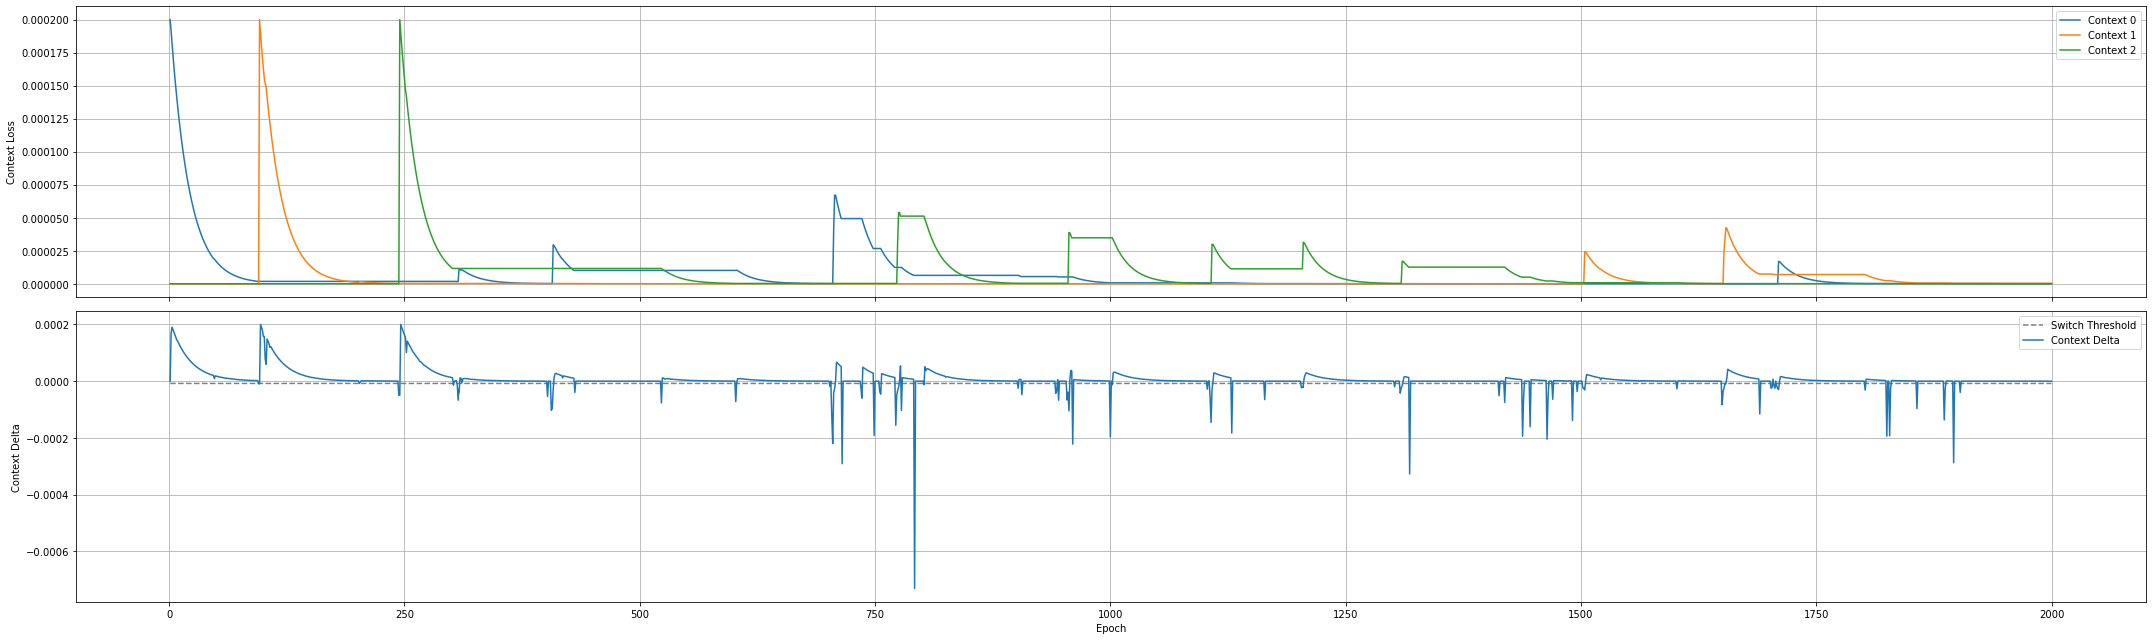

In [5]:
logger = ContextLogger()
logger.plots = data[(96, 3)][0]
logger.plot()

In [27]:
accuracies = 100*np.array([data[k][2] for k in sorted(data.keys())])

In [6]:
ci = 1.96 * np.std(accuracies, axis=0)/np.sqrt(len(accuracies))

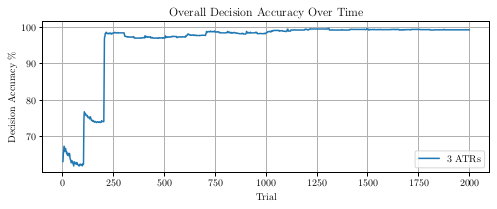

In [28]:
mpl.use("pgf")
mpl.rcParams.update({
                "pgf.texsystem": "pdflatex",
                "font.family": "serif",
                "text.usetex": True,
                "pgf.rcfonts": False
            })
fig, ax = plt.subplots(figsize=(7,3))
x, y = np.arange(a.shape[1]), np.mean(a, axis=0)
ax.plot(x, y, label=l)
# ax.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)
ax.set_xlabel("Trial")
ax.set_ylabel("Decision Accuracy %")
ax.set_title("Overall Decision Accuracy Over Time")
ax.grid()
ax.legend()
fig.tight_layout()
fig.savefig("graphs/wcst_accuracy.pgf")

In [43]:
len(accuracies)

100

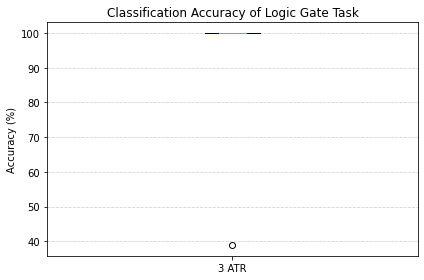

In [13]:
%matplotlib inline
fig, ax = plt.subplots()
labels = ["1 ATR", "3 ATRs"]
x_pos = np.arange(1, len(labels)+1)
ax.grid(True, axis='y', linestyle='--', color='lightgrey', zorder=0)
# for x, label in enumerate(labels):
ax.boxplot(accuracies[:,-1], notch=True, zorder=3)
ax.set_ylabel("Accuracy (%)")
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title("Classification Accuracy of Logic Gate Task")
plt.tight_layout()
plt.savefig("graphs/wcst_accuracy_boxplot.pgf")